In [1]:
!pip install shap
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 11.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.9 MB/s eta 0:00:00


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

512
0


  0%|          | 0/498 [00:00<?, ?it/s]

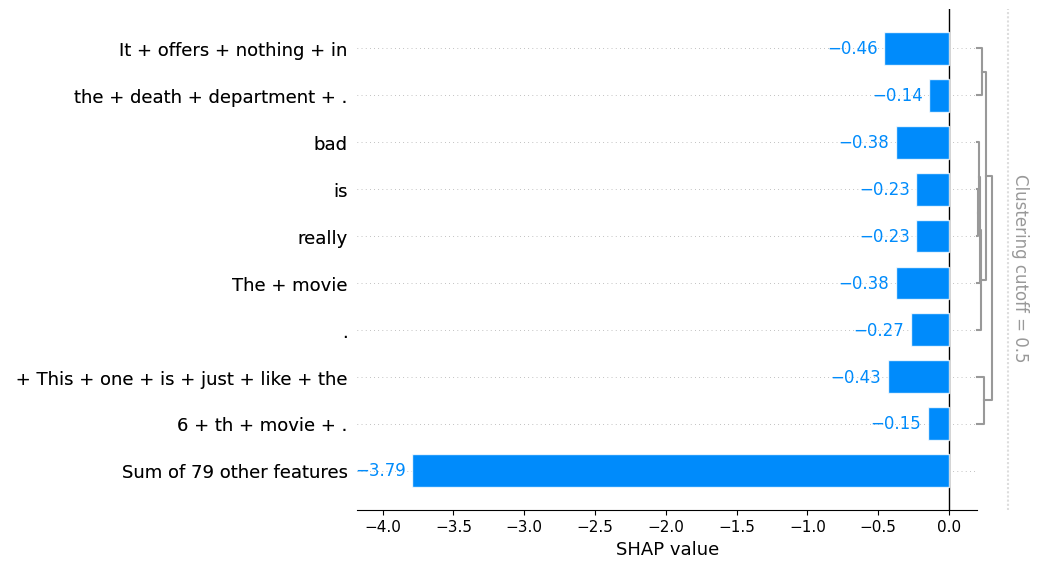

In [36]:
# Import required libraries
import numpy as np
import scipy as sp
import shap
import torch
import json
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline)


def load_model(model_path):
    # Load the tokenizer and model from the "roberta-base" pre-trained model
    tokenizer = AutoTokenizer.from_pretrained("roberta-base",use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained("roberta-base").cuda()

    # Load the saved state dict of the fine-tuned model
    model.load_state_dict(torch.load(model_path))

    return tokenizer, model


def preprocess_text(tokenizer, input_text, max_length):
    # Tokenize the input text using the tokenizer
    inputs = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        return_tensors="pt",
        max_length=max_length,
        truncation=True,
    )

    # Get the input_ids and attention_mask tensors
    return inputs["input_ids"].cuda(), inputs["attention_mask"].cuda()


def get_prediction(model, input_ids, attention_mask):
    # Get the predicted label using the input_ids and attention_mask
    outputs = model(input_ids, attention_mask=attention_mask)
    predicted_label = np.argmax(outputs.logits.detach().cpu().numpy())
    return predicted_label


def main():
    # Load the fine-tuned model from the saved state dict
    model_path = "/content/drive/MyDrive/DDA4210project/best_model.pt"
    tokenizer, model = load_model(model_path)
    print(tokenizer.model_max_length)
    labels = ["negative","positive"]

    test_data = "This one is just like the 6th movie. The movie is really bad. It offers nothing in the death department. The one-liners are bad and are something that shouldn't be in a NOES movie. Freddy comes off as a happy child in the whole movie. Lisa Wilcox is still the only thing that makes this one worth while. The characters are extremely underdeveloped. All in all better than the 6th one, but still one the worst movies of the series. My rating 2/10"
    device = 'cuda:0'

    input_ids, attention_mask = preprocess_text(
                tokenizer, test_data, max_length=512
            )
    predicted_label = get_prediction(model, input_ids, attention_mask)
    print(predicted_label)
    if predicted_label == 1:
      order = shap.Explanation.argsort.flip
    else:
      order = shap.Explanation.argsort

    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=device ,return_all_scores=True)
    pmodel = shap.models.TransformersPipeline(pipe, rescale_to_logits=True)
    explainer = shap.Explainer(pmodel,output_names=labels)
    shap_values = explainer([test_data])
    data = []
    '''for word in shap_values.data[0]:
      new_word = word.replace('Ġ', '')
      #new_word = new_word.replace('\n', '')
      data.append(new_word)
    shap_values.data = tuple([np.array(data)])'''
    shap.plots.text(shap_values[:,:,1])
    shap.plots.bar(shap_values[0,:,1], order=order)
            
    


if __name__ == "__main__":
    main()

NameError: ignored